In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import math, copy, time
import os
import pandas as pd
import torchinfo

import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

import lstm_encoder_decoder
import data_valuator
import funtions_for_dvrl

#import plotting

import json
import pickle

## Import Data 1

In [3]:
x = torch.tensor([2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 18, 17, 15, 14, 12, 11, 9, 8, 6, 5, 3, 2, 0, 1]).view(27,1)
y = torch.tensor([1]).view(1,1)
for i in range(1000):
    y = torch.cat((y,x), dim=0)

for j in range(2):
    y = torch.cat((y,y), dim=1)

y.shape

torch.Size([27001, 4])

In [4]:
dataset2 = y.numpy().astype(np.float64)
print(f"Shape : {dataset2.shape}, Data Type : {dataset2.dtype}")

Shape : (27001, 4), Data Type : float64


<function matplotlib.pyplot.show(close=None, block=None)>

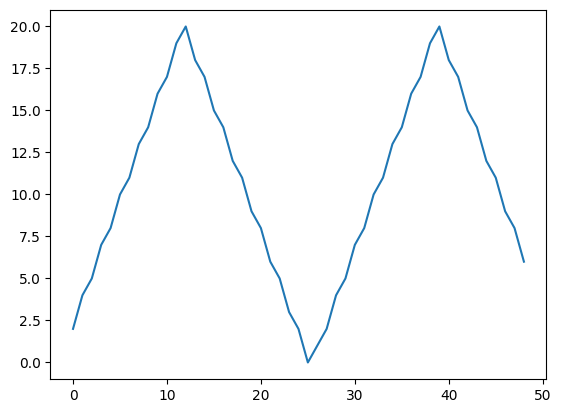

In [5]:
plt.plot(dataset2[1:50,2])
plt.show

## Import Data 2

In [6]:
pre = os.path.dirname(os.path.abspath('__file__'))
post = 'testPuneAQMNew_22.csv'
full_path = os.path.join(pre,post)
df = pd.read_csv(full_path)

In [7]:
print("DataFrame = {} rows {} columns".format(*df.shape))
display(df.head())

DataFrame = 16477 rows 19 columns


,airQualityLevel,observationDateTime,deviceStatus,aqiMajorPollutant,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime
0,VERY_POOR,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94
1,MODERATE,2022-01-01 00:01:08+05:30,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94
2,SEVERE,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94
3,VERY_POOR,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94
4,VERY_POOR,2022-01-01 00:01:09+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94


In [8]:
airQualityLevel_dict = {'SATISFACTORY': 1, 'MODERATE': 2, 'POOR': 3, 'VERY_POOR': 4, 'SEVERE': 5}
df['airQualityLevel_encod'] = df.airQualityLevel.map(airQualityLevel_dict)
df = df.drop(['airQualityLevel'], axis=1)
display(df.head())

,observationDateTime,deviceStatus,aqiMajorPollutant,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime,airQualityLevel_encod
0,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94,4.0
1,2022-01-01 00:01:08+05:30,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94,2.0
2,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94,5.0
3,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94,4.0
4,2022-01-01 00:01:09+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94,4.0


In [9]:
aqiMajorPollutant_dict = {'PM2.5': 1, 'CO': 2, 'NO2': 3}
df['aqiMajorPollutant_encod'] = df.aqiMajorPollutant.map(aqiMajorPollutant_dict)
df = df.drop(['aqiMajorPollutant'], axis=1)
display(df.head())

,observationDateTime,deviceStatus,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime,airQualityLevel_encod,aqiMajorPollutant_encod
0,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94,4.0,1.0
1,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94,2.0,2.0
2,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94,5.0,1.0
3,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94,4.0,1.0
4,2022-01-01 00:01:09+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94,4.0,1.0


In [10]:
features_considered = ['airQualityLevel_encod', 'aqiMajorPollutant_encod','airQualityIndex','uv.avgOverTime',
                       'o3.avgOverTime','pm2p5.avgOverTime','co2.avgOverTime','pm10.avgOverTime','co.avgOverTime','no2.avgOverTime',
                       'airTemperature.avgOverTime','illuminance.avgOverTime','ambientNoise.avgOverTime','so2.avgOverTime',
                       'relativeHumidity.avgOverTime','atmosphericPressure.avgOverTime']
features = df[features_considered]
features.index = df['observationDateTime']

In [11]:
dataset1 = features.values
print(f"Shape : {dataset2.shape}, Data Type : {dataset2.dtype}")

Shape : (27001, 4), Data Type : float64


In [12]:
device = torch.device("cpu")
torch.set_default_device(device)

In [16]:
y = np.array(dataset1[0:10000,10])
t = np.linspace(0., 10000, 10000)
print(y.shape, t.shape)

(10000,) (10000,)


## Baseline Data

<function matplotlib.pyplot.show(close=None, block=None)>

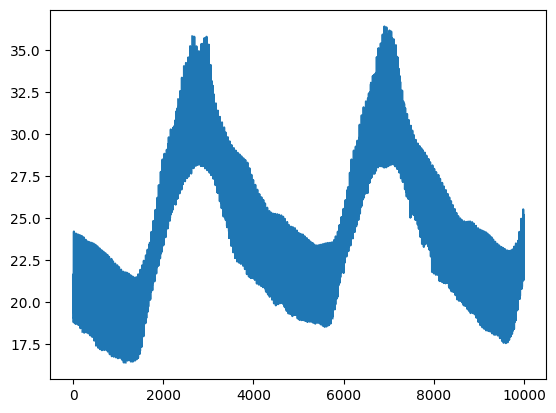

In [17]:
plt.plot(y)
plt.show

In [21]:
train_split = 8000
lookback = 80
lookahead = 10
step = 1
batch_size = 45

x_train_multi_baseline, y_train_multi_baseline = funtions_for_dvrl.multivariate_data(dataset1[:,10], dataset1[:,10], 0,
                                                 train_split, lookback,
                                                 lookahead, step)
x_val_multi_baseline, y_val_multi_baseline = funtions_for_dvrl.multivariate_data(dataset1[:,10], dataset1[:,10],
                                             train_split, 15000, lookback,
                                             lookahead, step)

print (
       'Train Dataset X Size : {}'.format(x_train_multi_baseline.shape),
       'Train Dataset Y Size : {}'.format(y_train_multi_baseline.shape),
       'Validation Dataset X Size : {}'.format(x_val_multi_baseline.shape),
       'Validation Dataset Y Size : {}'.format(y_val_multi_baseline.shape),
       sep='\n')

Train Dataset X Size : (7920, 80)
Train Dataset Y Size : (7920, 10)
Validation Dataset X Size : (6920, 80)
Validation Dataset Y Size : (6920, 10)


In [22]:
#Extracting a single column for univariante time series
x_train_baseline = torch.from_numpy(x_train_multi_baseline[:,:])
y_train_baseline = torch.from_numpy(y_train_multi_baseline[:,:])
x_valid_baseline = torch.from_numpy(x_val_multi_baseline[:,:])
y_valid_baseline = torch.from_numpy(y_val_multi_baseline[:,:])

x_valid_baseline = torch.unsqueeze(x_valid_baseline,2)
x_valid_baseline = x_valid_baseline.transpose(1,0).float()

y_valid_baseline = torch.unsqueeze(y_valid_baseline,2)
y_valid_baseline = y_valid_baseline.transpose(1,0).float()
print(f"X Train Shape : {x_train_baseline.shape}")
print(f"Y Train Shape : {y_train_baseline.shape}")
print(f"X Valid Shape : {x_valid_baseline.shape}")
print(f"Y Valid Shape : {y_valid_baseline.shape}")

X Train Shape : torch.Size([7920, 80])
Y Train Shape : torch.Size([7920, 10])
X Valid Shape : torch.Size([80, 6920, 1])
Y Valid Shape : torch.Size([10, 6920, 1])


In [23]:
x_train_baseline = x_train_baseline.to(device)
y_train_baseline = y_train_baseline.to(device)
x_valid_baseline = x_valid_baseline.to(device)
y_valid_baseline = y_valid_baseline.to(device)

## Corrupt Data

<function matplotlib.pyplot.show(close=None, block=None)>

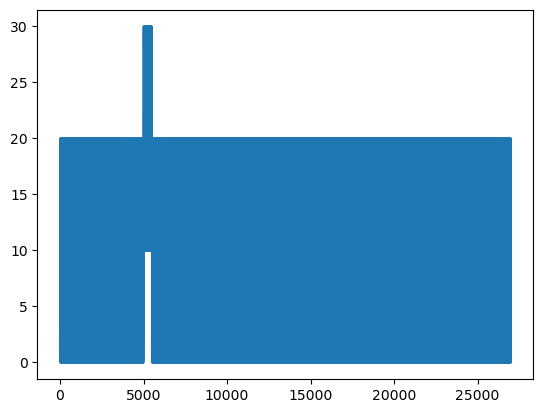

In [16]:
dataset1[:,10] += 10
#dataset2[10000:10050] += 700
plt.plot(dataset2[:,10])
plt.show

## Corrupted Dataset

In [17]:
train_split = 13081
lookback = 80
lookahead = 10
step = 1
batch_size = 45

x_train_multi, y_train_multi = funtions_for_dvrl.multivariate_data(dataset2, dataset2, 0,
                                                 train_split, lookback,
                                                 lookahead, step)
x_val_multi, y_val_multi = funtions_for_dvrl.multivariate_data(dataset2, dataset2,
                                             train_split, 15000, lookback,
                                             lookahead, step)

print (
       'Train Dataset X Size : {}'.format(x_train_multi.shape),
       'Train Dataset Y Size : {}'.format(y_train_multi.shape),
       'Validation Dataset X Size : {}'.format(x_val_multi.shape),
       'Validation Dataset Y Size : {}'.format(y_val_multi.shape),
       sep='\n')

Train Dataset X Size : (13001, 80, 4)
Train Dataset Y Size : (13001, 10, 4)
Validation Dataset X Size : (1839, 80, 4)
Validation Dataset Y Size : (1839, 10, 4)


In [18]:
#Extracting a single column for univariante time series
x_train = torch.from_numpy(x_train_multi[:,:,2])
y_train = torch.from_numpy(y_train_multi[:,:,2])
x_valid = torch.from_numpy(x_val_multi[:,:,2])
y_valid = torch.from_numpy(y_val_multi[:,:,2])

x_valid = torch.unsqueeze(x_valid,2)
x_valid = x_valid.transpose(1,0).float()

y_valid = torch.unsqueeze(y_valid,2)
y_valid = y_valid.transpose(1,0).float()
print(f"X Train Shape : {x_train.shape}")
print(f"Y Train Shape : {y_train.shape}")
print(f"X Valid Shape : {x_valid.shape}")
print(f"Y Valid Shape : {y_valid.shape}")

X Train Shape : torch.Size([13001, 80])
Y Train Shape : torch.Size([13001, 10])
X Valid Shape : torch.Size([80, 1839, 1])
Y Valid Shape : torch.Size([10, 1839, 1])


In [19]:
x_train = x_train.to(device)
y_train = y_train.to(device)
x_valid = x_valid.to(device)
y_valid = y_valid.to(device)

## Make Model

In [20]:
def make_model(lookback = lookback, lookahead = lookahead, datavaluator_hidden = 64):
    "Helper: Construct a model from hyperparameters."
    #c = copy.deepcopy
    #data_valuator_mlp = Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    model_1 = data_valuator.Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    return model_1

In [21]:
model_1 = make_model()
model_1.to(device)
moving_avg_loss = 0

In [22]:
torchinfo.summary(model_1, [(batch_size, lookback + lookahead)], dtypes=[torch.float64, torch.float64], col_names=["input_size", "output_size", 
                                                                                                 "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Data_Valuator_MLP                        [45, 90]                  [45, 1]                   --                        True
├─Sequential: 1-1                        [45, 90]                  [45, 1]                   --                        True
│    └─Linear: 2-1                       [45, 90]                  [45, 64]                  5,824                     True
│    └─ReLU: 2-2                         [45, 64]                  [45, 64]                  --                        --
│    └─Linear: 2-3                       [45, 64]                  [45, 128]                 8,320                     True
│    └─ReLU: 2-4                         [45, 128]                 [45, 128]                 --                        --
│    └─Linear: 2-5                       [45, 128]                 [45, 64]                  8,256                     True
│    └─

## Train Baseline Model LSTM

In [24]:
iteration_baseline = []
train_loss_plot_baseline = []

In [25]:
model_baseline = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 128)
model_baseline.to(device)

lstm_seq2seq(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 128)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 128)
    (linear): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [26]:
learning_rate_for_lstm = 0.01
time_window_size = 45
num_of_epochs_baseline = 5
iter_baseline = 0
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr = learning_rate_for_lstm)

In [27]:
for i in range(num_of_epochs_baseline):
    for T in range(12500):
        
        #Make Time Window Batches
        x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train_baseline, y_train_baseline, time_window_size, T)
        if T % 1000 == 0:
            print(f'Iteration = {iter_baseline}')
        #Reshape For LSTM
        x_selected_batch = torch.unsqueeze(x_batch,2)
        x_selected_batch = x_selected_batch.transpose(1,0).float()
        y_selected_batch = torch.unsqueeze(y_batch,2)
        y_selected_batch = y_selected_batch.transpose(1,0).float()
        #Pass Through LSTM
        loss, lstm_predict = model_baseline.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
                             optimizer = optimizer_baseline, training_prediction = 'recursive', learning_rate = learning_rate_for_lstm, dynamic_tf = False)
        if T == 0 and i == 2:
            torch.save({
                'model_state_dict': model_baseline.state_dict()
                }, '/home/student/Desktop/Ayush-Ashis/models/model_baseline_iter2.pth')
        #Plot Everything
        train_loss_plot_baseline.append(loss)
        iteration_baseline.append(iter_baseline)
        iter_baseline+=1
        if T%1000 == 0:
            print(f"curr_loss = {loss}")

Iteration = 0
curr_loss = 152.44656372070312
Iteration = 1000
curr_loss = 0.23904649913311005
Iteration = 2000
curr_loss = 0.19898104667663574
Iteration = 3000
curr_loss = 0.07696469873189926
Iteration = 4000
curr_loss = 0.042058445513248444
Iteration = 5000
curr_loss = 0.2238229215145111
Iteration = 6000
curr_loss = 2.6543827056884766
Iteration = 7000
curr_loss = 0.08621387183666229
Iteration = 8000
curr_loss = 0.013633264228701591
Iteration = 9000
curr_loss = 0.010419484227895737
Iteration = 10000
curr_loss = 0.0019270251505076885
Iteration = 11000
curr_loss = 1.06972074508667
Iteration = 12000
curr_loss = 0.0038259602151811123
Iteration = 12500
curr_loss = 0.0016840063035488129
Iteration = 13500
curr_loss = 0.004902174696326256
Iteration = 14500
curr_loss = 0.009184790775179863
Iteration = 15500
curr_loss = 0.00165733287576586
Iteration = 16500
curr_loss = 0.034996453672647476
Iteration = 17500
curr_loss = 0.0092521533370018
Iteration = 18500
curr_loss = 0.1515929400920868
Iteration

KeyboardInterrupt: 

In [28]:
torch.save({
            'model_state_dict': model_baseline.state_dict()
            }, '/home/student/Desktop/Ayush-Ashis/models/model_baseline.pth')

In [29]:
# for i in range(len(train_loss_plot)):
#     train_loss_plot[i] = train_loss_plot[i].to("cpu")

In [30]:
# len(train_loss_plot)

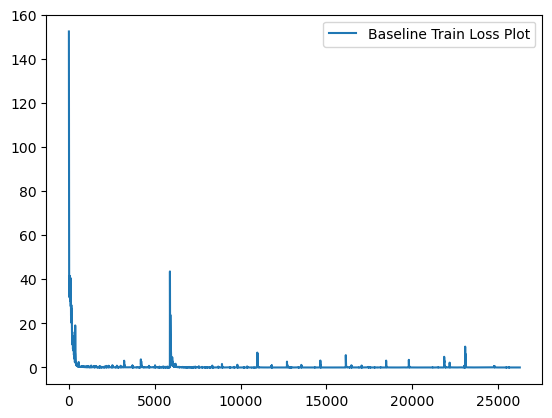

In [31]:
train_loss_plot_list_baseline = [tensor for tensor in train_loss_plot_baseline]
#mean_of_prob_list = [tensor for tensor in mean_of_prob]
iteration_plot_list = iteration_baseline
plt.plot(iteration_plot_list, train_loss_plot_list_baseline, label='Baseline Train Loss Plot')
plt.legend()
plt.show()

## Train Model DVRL

In [32]:
model_baseline = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 128)
checkpoint_baseline = torch.load('/home/student/Desktop/Ayush-Ashis/models/model_baseline.pth')
model_baseline.load_state_dict(checkpoint_baseline['model_state_dict'])

<All keys matched successfully>

In [33]:
criterion_for_lstm = funtions_for_dvrl.RMSELoss()

In [34]:
y_hat_valid_baseline = model_baseline.predict(x_valid_baseline, y_valid_baseline.shape[0], x_valid_baseline.shape[1])
val_loss_baseline = criterion_for_lstm(y_hat_valid_baseline,y_valid_baseline)

In [35]:
val_loss_baseline

tensor(0.0629, device='cuda:0')

In [66]:
for p in model_1.parameters():
    p.requires_grad = True #False


mov_avg_plot = []
reward_plot = []
val_loss_plot = []
iteration = []
mean_of_hidden = []
mean_of_prob = []
train_loss_plot = []
lstm_predict_plot = []

In [67]:
# prob = torch.sum(select * (est_data_value + epsilon).log() + (1-select) * (1 - est_data_value + self.epsilon).log())
# dve_loss = (-reward * prob) + 
#     1e3 * (torch.maximum(torch.mean(est_data_value) - threshold, 0) + torch.maximum((1-threshold) - torch.mean(est_data_value), 0))

In [68]:
# def print_weights(module):
#     for value in module.state_dict():
#         param = module.state_dict()[value]
#         print(value, param)
# print_weights(model_1)

In [69]:
model_1 = make_model()

checkpoint = torch.load('/home/student/Desktop/Ayush-Ashis/models/data_valuator.pth')
model_1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [70]:
## MLP MODEL

reward = 0
model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 128)
checkpoint_iter2 = torch.load('/home/student/Desktop/Ayush-Ashis/models/model_new_lstm.pth')
model_4.load_state_dict(checkpoint_iter2['model_state_dict'])
model_4.to(device)
learning_rate_for_dve = 0.0001
learning_rate_for_lstm = 0.01
time_window_size = 45
reward = -10
num_of_epochs = 7 
iter = 0
threshold = 0.9
epsilon = 1e-8
optim_for_dve = torch.optim.Adam(model_1.parameters(), lr=learning_rate_for_dve)
optim_for_lstm = optim.Adam(model_4.parameters(), lr = learning_rate_for_lstm)

In [71]:
for i in range(num_of_epochs):
    for T in range(11000):
        
        #Make Time Window Batches
        if T == 10000:
            break
        x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        input = torch.cat((x_batch,y_batch), 1).to(device)
        prob_vector, hid = model_1.forward(input)
        #if i == 0:
            #prob_vector = torch.ones(x_batch.shape[0],1)
        select = funtions_for_dvrl.SelectionFromProb_2(prob_vector)
        select_for_lstm = select.clone().detach().to(device)
        x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
        mean = torch.mean(prob_vector).clone().detach()
        mean_hid = torch.mean(hid).clone().detach()
        mean_of_hidden.append(mean)
        mean_of_prob.append(mean_hid)
        # if torch.all(select==0).item():
        #     continue
        if T % 1000 == 0:
            print(f'Iteration = {iter}')
            print(f'Mean Of Prob Vector = {mean}')
            print(f'Prob Vector = {prob_vector}')
            print(f'Mean Of Hidden Vector = {mean_hid}')
            print(f'Hidden State Just Before Sigmoid = {hid}')
        #Reshape For LSTM
        x_selected_batch = torch.unsqueeze(x_selected_batch,2)
        x_selected_batch = x_selected_batch.transpose(1,0).float().detach()
        y_selected_batch = torch.unsqueeze(y_selected_batch,2)
        y_selected_batch = y_selected_batch.transpose(1,0).float().detach()
        #Pass Through LSTM
        loss, lstm_predict = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
                             optimizer = optim_for_lstm, training_prediction = 'recursive', learning_rate = learning_rate_for_lstm, dynamic_tf = False)
        y_hat_valid = model_4.predict(x_valid, y_valid.shape[0], x_valid.shape[1])
        val_loss = criterion_for_lstm(y_hat_valid,y_valid)
        #Update The Moving Average
        #moving_avg_loss = funtions_for_dvrl.MAL(val_loss, T+1, moving_avg_loss)
        #Determine The Log_Pi Loss And Reward Scale
        reward = val_loss_baseline - val_loss
        # if torch.eq(reward,0).item():
        #     reward = torch.tensor(-1)
        #Update The Data Valuator Parameters
        #reward_for_data = reward.clone().detach()
        data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi_2(select_for_lstm, prob_vector, epsilon, threshold, -abs(reward), explore_parameter=1e3)
        #Plot Everything
        lstm_predict_plot.append(lstm_predict)
        train_loss_plot.append(loss)
        mov_avg_plot.append(data_valuator_loss)
        reward_plot.append(reward)
        val_loss_plot.append(val_loss)
        iteration.append(iter)
        iter+=1
        if T%1000 == 0:
            print(f"curr_loss = {val_loss}, mov_avg = {data_valuator_loss}, reward = {reward}, val_base = {val_loss_baseline}")
        #if i == 0:
            #continue
        if T in range(5100,5110):
            print(f'Iteration = {iter}')
            print(f'Mean Of Prob Vector = {mean}')
            print(f'Prob Vector = {prob_vector}')
            print(f'Hidden State Just Before Sigmoid = {hid}')
            print(f'Reward = {reward}')
        optim_for_dve.zero_grad()
        data_valuator_loss.backward()
        optim_for_dve.step()

Iteration = 0
Mean Of Prob Vector = 0.49437934160232544
Prob Vector = tensor([[0.4941],
        [0.4922],
        [0.4923],
        [0.4910],
        [0.4920],
        [0.4917],
        [0.4927],
        [0.4929],
        [0.4942],
        [0.4951],
        [0.4946],
        [0.4939],
        [0.4920],
        [0.4918],
        [0.4922],
        [0.4934],
        [0.4943],
        [0.4953],
        [0.4976],
        [0.4998],
        [0.5026],
        [0.5030],
        [0.5025],
        [0.5007],
        [0.4989],
        [0.4969],
        [0.4938],
        [0.4941],
        [0.4922],
        [0.4923],
        [0.4910],
        [0.4920],
        [0.4917],
        [0.4927],
        [0.4929],
        [0.4942],
        [0.4951],
        [0.4946],
        [0.4939],
        [0.4920],
        [0.4918],
        [0.4922],
        [0.4934],
        [0.4943],
        [0.4953]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Mean Of Hidden Vector = -0.022484231740236282
Hidden State Just Before Sig

KeyboardInterrupt: 

In [72]:
# for i in range(num_of_epochs):
#     for T in range(11000):
        
#         #Make Time Window Batches
#         if T == 10000:
#             break
#         x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
#         #Pass Throught Data Valuator MLP
#         input = torch.cat((x_batch,y_batch), 1).to(device)
#         prob_vector, hid = model_1.forward(input)
#         #if i == 0:
#             #prob_vector = torch.ones(x_batch.shape[0],1)
#         select = funtions_for_dvrl.SelectionFromProb_2(prob_vector)
#         select_for_lstm = select.clone().detach().to(device)
#         x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
#         mean = torch.mean(prob_vector).clone().detach()
#         mean_hid = torch.mean(hid).clone().detach()
#         mean_of_hidden.append(mean)
#         mean_of_prob.append(mean_hid)
#         # if torch.all(select==0).item():
#         #     continue
#         if T % 1000 == 0:
#             print(f'Iteration = {iter}')
#             print(f'Mean Of Prob Vector = {mean}')
#             print(f'Prob Vector = {prob_vector}')
#             print(f'Mean Of Hidden Vector = {mean_hid}')
#             print(f'Hidden State Just Before Sigmoid = {hid}')
#         #Reshape For LSTM
#         x_selected_batch = torch.unsqueeze(x_selected_batch,2)
#         x_selected_batch = x_selected_batch.transpose(1,0).float()
#         y_selected_batch = torch.unsqueeze(y_selected_batch,2)
#         y_selected_batch = y_selected_batch.transpose(1,0).float()
#         #Pass Through LSTM
#         loss, lstm_predict = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
#                              optimizer = optim_for_lstm, training_prediction = 'recursive', learning_rate = learning_rate_for_lstm, dynamic_tf = False)
#         y_hat_valid = model_4.predict(x_valid, y_valid.shape[0], x_valid.shape[1])
#         val_loss = criterion_for_lstm(y_hat_valid,y_valid)
#         #Update The Moving Average
#         moving_avg_loss = funtions_for_dvrl.MAL(val_loss, T+1, moving_avg_loss)
#         #Determine The Log_Pi Loss And Reward Scale
#         reward = val_loss - moving_avg_loss
#         # if torch.eq(reward,0).item():
#         #     reward = torch.tensor(-1)
#         #Update The Data Valuator Parameters
#         #reward_for_data = reward.clone().detach()
#         data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi_2(select_for_lstm, prob_vector, epsilon, threshold, reward, explore_parameter=1e5)
#         #Plot Everything
#         lstm_predict_plot.append(lstm_predict)
#         train_loss_plot.append(loss)
#         mov_avg_plot.append(moving_avg_loss)
#         reward_plot.append(reward)
#         val_loss_plot.append(val_loss)
#         iteration.append(iter)
#         iter+=1
#         if T%1000 == 0:
#             print(f"curr_loss = {val_loss}, mov_avg = {moving_avg_loss}, reward = {reward}")
#         #if i == 0:
#             #continue
#         if T in range(5100,5110):
#             print(f'Iteration = {iter}')
#             print(f'Mean Of Prob Vector = {mean}')
#             print(f'Prob Vector = {prob_vector}')
#             print(f'Hidden State Just Before Sigmoid = {hid}')
#             print(f'Reward = {reward}')
#         optim_for_dve.zero_grad()
#         data_valuator_loss.backward()
#         optim_for_dve.step()

In [73]:
# ## MLP MODEL

# reward = 0
# model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 32)
# num_of_epochs = 3
# iter = 0
# for i in range(num_of_epochs):
#     for T in range(7000):
        
#         #Make Time Window Batches
#         if T == 7000:
#             break
#         x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
#         #Pass Throught Data Valuator MLP
#         input = torch.cat((x_batch,y_batch), 1)
#         prob_vector, hid = model_1.forward(input)
#         select = data_valuator.SelectionFromProb(prob_vector, g)
#         select_for_lstm = select.clone().detach()
#         x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
#         mean = torch.mean(prob_vector).clone().detach()
#         mean_hid = torch.mean(hid).clone().detach()
#         mean_of_hidden.append(mean)
#         mean_of_prob.append(mean_hid)
#         if torch.all(select==0).item():
#             continue
#         if T % 1000 == 0:
#             print(f'Iteration = {iter}')
#             print(f'Mean Of Prob Vector = {mean}')
#             print(f'Prob Vector = {prob_vector}')
#             print(f'Mean Of Hidden Vector = {mean_hid}')
#             print(f'Hidden State Just Before Sigmoid = {hid}')
#         #Reshape For LSTM
#         x_selected_batch = torch.unsqueeze(x_selected_batch,2)
#         x_selected_batch = x_selected_batch.transpose(1,0).float()
#         y_selected_batch = torch.unsqueeze(y_selected_batch,2)
#         y_selected_batch = y_selected_batch.transpose(1,0).float()
#         #Pass Through LSTM
#         loss = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
#                              training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.6, learning_rate = learning_rate, dynamic_tf = False)
#         curr_lossi = lstm_encoder_decoder.predict_loss(model_4, x_valid, y_valid)
#         curr_loss = torch.tensor(curr_lossi)
#         #Update The Moving Average
#         moving_avg_loss = funtions_for_dvrl.MAL(curr_loss, T+1, moving_avg_loss)
#         #Determine The Log_Pi Loss And Reward Scale
#         reward = curr_loss - moving_avg_loss
#         data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi(select, prob_vector)
#         if torch.eq(reward,0).item():
#             reward = torch.tensor(-1)
#         #Update The Data Valuator Parameters
#         reward_for_data = reward.clone().detach()
#         mov_avg_plot.append(moving_avg_loss)
#         reward_plot.append(reward)
#         val_loss_plot.append(curr_loss)
#         iteration.append(iter)
#         iter+=1
#         if T%1000 == 0:
#             print(f"curr_loss = {curr_loss}, mov_avg = {moving_avg_loss}, reward = {reward}")
#         if i == 0:
#             continue
#         if T in range(5100,5110):
#             print(f'Iteration = {iter}')
#             print(f'Mean Of Prob Vector = {mean}')
#             print(f'Prob Vector = {prob_vector}')
#             print(f'Hidden State Just Before Sigmoid = {hid}')
#             print(f'Reward = {reward}')
        
#         data_valuator_loss.backward()
#         #if T % 1000 == 0:
#             #print(f'Gradient Of ih_l0 Layer = {model_5.lstm.weight_ih_l0.grad}')

#         #Train Data Valuator
#         for p in model_1.parameters():
#             p.data.add_(-reward * alpha * p.grad.data)#Beta = 0.001
#             if p.grad is not None:
#                 p.grad.detach_()
#                 p.grad.zero_()

In [74]:
for i in range(len(mean_of_hidden)):
    mean_of_hidden[i] = mean_of_hidden[i].to("cpu")
for i in range(len(val_loss_plot)):
    val_loss_plot[i] = val_loss_plot[i].to("cpu")
for i in range(len(reward_plot)):
    reward_plot[i] = reward_plot[i].to("cpu")

In [77]:
reward_plot[0:10]

[tensor(-3.2054),
 tensor(-0.7853),
 tensor(-2.2932),
 tensor(-2.9445),
 tensor(-2.0365),
 tensor(-0.8388),
 tensor(-1.0013),
 tensor(-1.8139),
 tensor(-2.0696),
 tensor(-1.8149)]

In [78]:
for i in range(len(mov_avg_plot)):
    mov_avg_plot[i] = mov_avg_plot[i].to("cpu").detach().numpy()

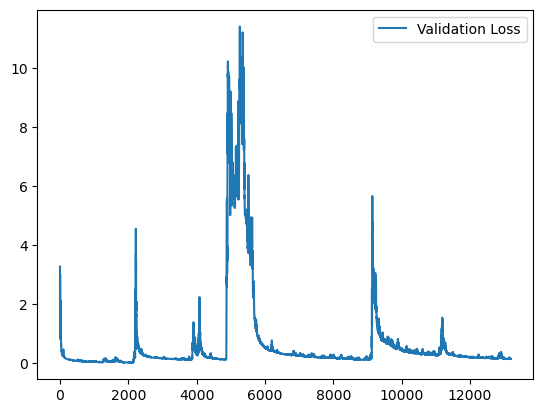

In [79]:
val_plot_list = [tensor for tensor in val_loss_plot]
reward_plot_list = [tensor for tensor in reward_plot]
#mov_avg_plot_list = [tensor for tensor in mov_avg_plot]
mean_of_hidden_list = [tensor for tensor in mean_of_hidden]
#mean_of_prob_list = [tensor for tensor in mean_of_prob]
iteration_plot_list = iteration
plt.plot(iteration, val_plot_list, label='Validation Loss')
# plt.plot(iteration, mov_avg_plot_list, label='Moving Avg Loss')
#plt.plot(iteration, x_train[0:800,2], label='Dataset')
#plt.ylabel('Losses')
#plt.xlabel('Iteration')
plt.legend()
plt.show()

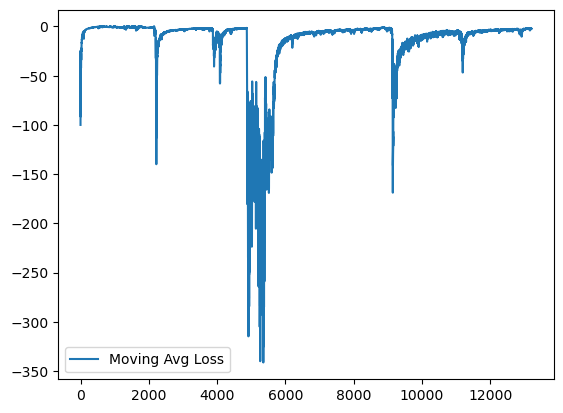

In [80]:
mov_avg_plot_list = [tensor for tensor in mov_avg_plot]
plt.plot(iteration, mov_avg_plot_list, label='Moving Avg Loss')
plt.legend()
plt.show()

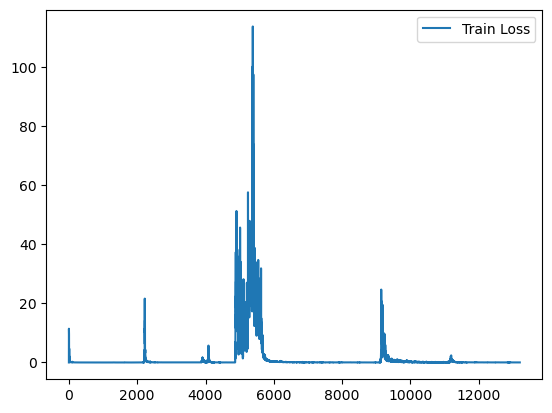

In [81]:
plt.plot(iteration, train_loss_plot, label='Train Loss')
plt.legend()
plt.show()

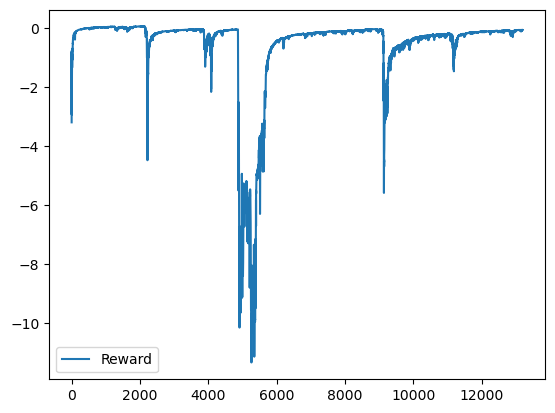

In [82]:
plt.plot(iteration, reward_plot_list, label='Reward')
plt.legend()
plt.show()

In [83]:
mee = []
for i in range(len(mean_of_hidden_list)):
    mee.append(mean_of_hidden_list[i].clone().detach())

In [84]:
for i in range(len(mee)):
    mee[i] = mee[i].to("cpu")

In [85]:
meean_of_hidden_list = [tensor for tensor in mee]

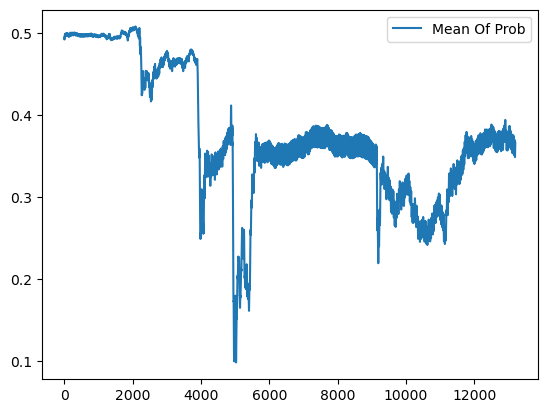

In [86]:
plt.plot(meean_of_hidden_list, label='Mean Of Prob')
plt.legend()
plt.show()

In [87]:
meee = []
for i in range(len(mean_of_prob)):
    meee.append(mean_of_prob[i].clone().detach())

In [57]:
for i in range(len(mee)):
    meee[i] = meee[i].to("cpu")

In [58]:
meeean_of_hidden_list = [tensor for tensor in meee]

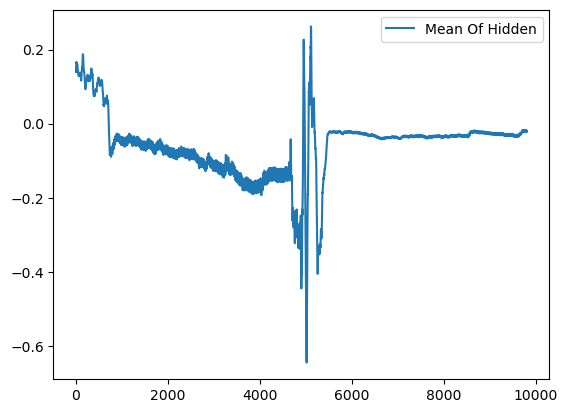

In [59]:
plt.plot(meeean_of_hidden_list, label='Mean Of Hidden')
plt.legend()
plt.show()

In [88]:
torch.save({
            'model_state_dict': model_4.state_dict(),
            }, '/home/student/Desktop/Ayush-Ashis/models/model_new_lstm.pth')

In [89]:
torch.save({
            'model_state_dict': model_1.state_dict(),
            }, '/home/student/Desktop/Ayush-Ashis/models/data_valuator.pth')

In [ ]:
asymtote = 0

In [ ]:
# ## HMM MODEL

# reward = 0
# model_5 = data_valuator.Data_Valuator_LSTM(input_size = 1, hidden_size = 32, 5)
# model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 64)
# num_of_epochs = 4
# iter = 0
# for i in range(num_of_epochs):
#     moving_avg_loss = 0
#     for T in range(23000):
        
#         #Make Time Window Batches
#         if T == 23000:
#             break
#         x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
#         #Pass Throught Data Valuator MLP
#         x_batch_reshape = torch.unsqueeze(x_batch, 2)
#         x_batch_reshape = x_batch_reshape.transpose(1,0).float()
#         encoder_hidden = model_5.init_hidden()
#         encoder_output, encoder_hidden = model_5(x_batch_reshape)
#         prob_vector = encoder_hidden.view(x_batch.shape[0],1)
#         if i == 0:
#             prob_vector = torch.ones(x_batch.shape[0],1)
#         select = data_valuator.SelectionFromProb(prob_vector, g)
#         select_for_lstm = select.clone().detach()
#         x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
#         if torch.all(select==0).item():
#             continue
#         #Reshape For LSTM
#         x_selected_batch = torch.unsqueeze(x_selected_batch,2)
#         x_selected_batch = x_selected_batch.transpose(1,0).float()
#         y_selected_batch = torch.unsqueeze(y_selected_batch,2)
#         y_selected_batch = y_selected_batch.transpose(1,0).float()
#         #Pass Through LSTM
#         loss = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
#                              training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.2, learning_rate = learning_rate, dynamic_tf = False)
#         curr_lossi = lstm_encoder_decoder.predict_loss(model_4, x_valid, y_valid)
#         val_loss = torch.tensor(curr_lossi)
#         #Update The Moving Average
#         moving_avg_loss = funtions_for_dvrl.MAL(val_loss, T+1, moving_avg_loss)
#         reward = funtions_for_dvrl.HMM(val_loss, T+1, asymtote)
#         #Determine The Log_Pi Loss And Reward Scale
#         #reward = val_loss - moving_avg_loss
#         data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi(select, prob_vector)
#         if torch.eq(reward,0).item():
#             reward = torch.tensor(-1)
#         #Update The Data Valuator Parameters
#         reward_for_data = reward.clone().detach()
#         mov_avg_plot.append(moving_avg_loss)
#         if i == 0 :
#             reward_for_data = 0
#         reward_plot.append(reward_for_data)
#         val_loss_plot.append(val_loss)
#         iteration.append(iter)
#         iter+=1
#         if T%1000 == 0:
#             print(f"val_loss = {val_loss}, mov_avg = {moving_avg_loss}, reward = {reward_for_data}")
#         if i == 0:
#             asymtote = moving_avg_loss/2
#             continue
#         data_valuator.Data_Valuator_Train(model_5, data_valuator_loss, reward_for_data, alpha)

In [ ]:
print(model_5.state_dict())

In [ ]:
def print_weights(module):
    for value in module.state_dict():
        param = module.state_dict()[value]
        print(value,param.shape,param.grad)
        
print_weights(model_5)

In [ ]:
print(model_5.lstm.weight_ih_l0.grad)

In [ ]:
iteration[-1]

In [ ]:
## INCREASED HIDDEN SIZE MODEL + IIR

reward = 0
model_5 = data_valuator.Data_Valuator_LSTM(input_size = 1, hidden_size = 32, batch_size = 45)
model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 64)
num_of_epochs = 10
iter = 0
moving_avg_loss = 0
reward = 0
beta = 0.1
for i in range(num_of_epochs):
    for T in range(12000):
        
        #Make Time Window Batches
        if T == 11000:
            break
        x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        x_batch_reshape = torch.unsqueeze(x_batch, 2)
        x_batch_reshape = x_batch_reshape.transpose(1,0).float()
        #print(x_batch_reshape.shape)
        intialized_hidden = model_5.init_hidden()
        encoder_hidden, hid = model_5(x_batch_reshape, intialized_hidden)
        #print(encoder_hidden.shape)
        #print(encoder_hidden)
        prob_vector = encoder_hidden.view(x_batch.shape[0],1)
        mean = torch.mean(prob_vector).clone().detach()
        mean_hid = torch.mean(hid).clone().detach()
        #print(torch.mean(prob_vector).clone().detach())
        mean_of_hidden.append(mean)
        mean_of_prob.append(mean_hid)
        if i % 1 == 0:
            prob_vector = torch.ones(x_batch.shape[0],1)
        select = data_valuator.SelectionFromProb(prob_vector, g)
        #print(prob_vector.shape)
        #print(prob_vector)
        #print(select.shape)
        if T % 1000 == 0:
            print(f'Iteration = {iter}')
            print(f'Mean Of Prob Vector = {mean}')
            print(f'Prob Vector = {prob_vector}')
            print(f'Mean Of Hidden Vector = {mean_hid}')
            print(f'Hidden State Just Before Sigmoid = {hid}') # hid is the inside of linear layer in sigmoid
            
        select_for_lstm = select.clone().detach()
        x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
        if torch.all(select==0).item():
            continue
        #Reshape For LSTM
        x_selected_batch = torch.unsqueeze(x_selected_batch,2)
        x_selected_batch = x_selected_batch.transpose(1,0).float()
        y_selected_batch = torch.unsqueeze(y_selected_batch,2)
        y_selected_batch = y_selected_batch.transpose(1,0).float()
        #Pass Through LSTM
        loss = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = lookahead, batch_size = x_selected_batch.shape[1], 
                             training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.2, learning_rate = learning_rate, dynamic_tf = False)
        curr_lossi = lstm_encoder_decoder.predict_loss(model_4, x_valid, y_valid)
        val_loss = torch.tensor(curr_lossi)
        #Update The Moving Average
        moving_avg_loss = funtions_for_dvrl.IIR(val_loss, iter+1, moving_avg_loss, beta)
        #moving_avg_loss = funtions_for_dvrl.MAL(val_loss, iter+1, moving_avg_loss)
        #Determine The Log_Pi Loss And Reward Scale
        reward = val_loss - moving_avg_loss
        data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi(select, prob_vector)
        if torch.eq(reward,0).item():
            reward = torch.tensor(-1)
        #Update The Data Valuator Parameters
        reward_for_data = reward.clone().detach()
        mov_avg_plot.append(moving_avg_loss)
        reward_plot.append(reward_for_data)
        val_loss_plot.append(val_loss)
        iteration.append(iter)
        iter+=1
        if T%1000 == 0:
            print(f"val_loss = {val_loss}, avg_loss = {moving_avg_loss}, reward = {reward_for_data}")
        if i % 1 == 0:
            continue
        if T in range(5100,5110):
            print(f'Iteration = {iter}')
            print(f'Mean Of Prob Vector = {mean}')
            print(f'Prob Vector = {prob_vector}')
            print(f'Hidden State Just Before Sigmoid = {hid}')
            print(f'Reward = {reward}')
        
        data_valuator_loss.backward()
        #if T % 1000 == 0:
            #print(f'Gradient Of ih_l0 Layer = {model_5.lstm.weight_ih_l0.grad}')

        #Train Data Valuator
        for p in model_5.parameters():
            p.data.add_(-reward * alpha * p.grad.data)#Beta = 0.001
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()
        #if T % 1000 == 0:
            #print(model_5.lstm.weight_ih_l0.data)